# Importation des librairies

In [38]:
import cv2 
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.utils import config_util #Necessite etre dans le dossier research {cd /content/drive/MyDrive/Object_detection_TF/Tensorflow/models/research}
from object_detection.builders import model_builder

# Déclaration des chemins

In [99]:
CHEMIN_FICHIER = 'images/Joseph16.jpg'
PIPELINE_CONFIG = 'model/pipeline.config'
CHEMIN_LABEL = 'config/label_map.pbtxt'
MODEL = 'model'

# Chargement du model

In [51]:
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# # chargement de checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(MODEL,'export','checkpoint', 'ckpt-0')).expect_partial()


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Recupération de l'image à prédire et des Labels

In [100]:
category_index = label_map_util.create_category_index_from_labelmap(CHEMIN_LABEL)
# category_index = [{'name':'joseph', 'id':1}, {'name':'felix', 'id':2}]
print(category_index)
img = cv2.imread(CHEMIN_FICHIER)
image_np = np.array(img)

{2: {'id': 2, 'name': 'felix'}, 1: {'id': 1, 'name': 'joseph'}}


# Prédiction

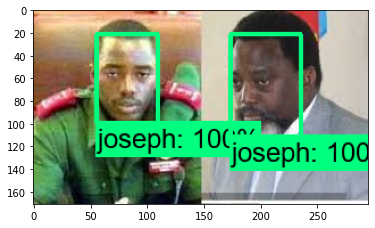

In [101]:
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))

detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()